In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt

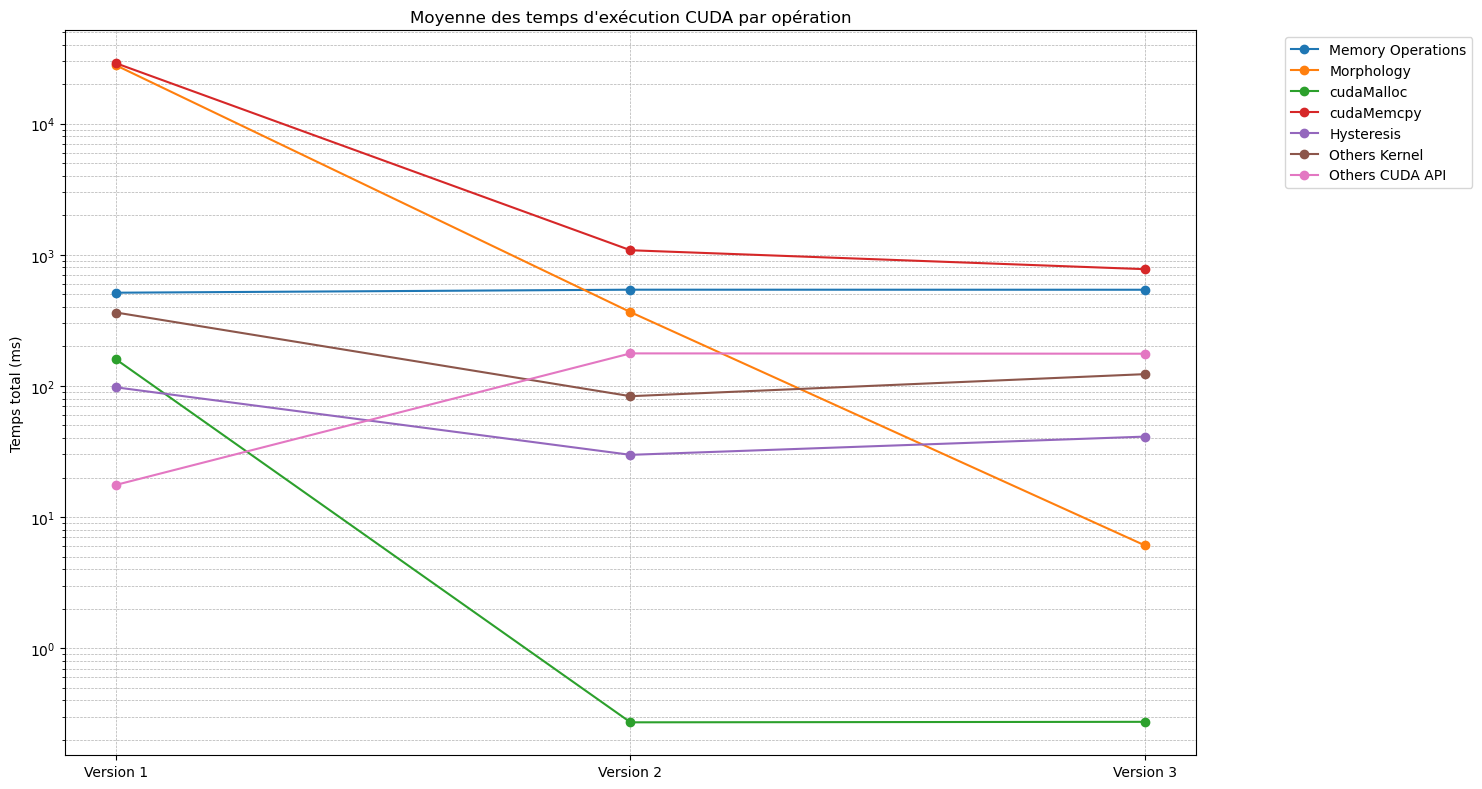

In [18]:
def load_cuda_data(file_path="cuda_summary.json"):
    with open(file_path, 'r') as f:
        return json.load(f)

def group_operations(data_dict):
    groups = {
        "Memory Operations": ["[CUDA memcpy Device-to-Host]", "[CUDA memcpy Host-to-Device]"],
        "Morphology": ["morphologicalErosionKernel", "morphologicalDilationKernel", "dilation_column_major", "dilation_row_major", "erosion_column_major", "erosion_row_major"],
        "cudaMalloc": ["cudaMalloc", "cudaMallocPitch"],
        "cudaMemcpy": ["cudaMemcpy", "cudaMemcpy2DAsync"],
        "Hysteresis": ["hysterisis", "hysteresisThresholdingKernel"],
        "Others Kernel": ["applyMotionMaskKernel", "apply_red", "detectMotionKernel", "motion_detect", "motion_first_frame"],
        "Others CUDA API": ["cudaStreamSynchronize", "cudaStreamCreate", "cudaLaunchKernel", "cudaDeviceSynchronize"]
    }

    grouped_data = {}
    used_keys = set()

    for new_key, keys_to_merge in groups.items():
        grouped_data[new_key] = sum(data_dict.get(k, 0) for k in keys_to_merge)
        used_keys.update(keys_to_merge)

    for k, v in data_dict.items():
        if k not in used_keys:
            grouped_data[k] = v

    return grouped_data

def prepare_plot_data(cuda_data):
    raw_data = {}

    for entry in cuda_data:
        version = entry["version"]
        data_grouped = group_operations(entry["data"])

        if version not in raw_data:
            raw_data[version] = []
        raw_data[version].append(data_grouped)

    avg_data = {}
    for version, video_list in raw_data.items():
        df = pd.DataFrame(video_list)
        avg_data[version] = df.mean()

    return pd.DataFrame(avg_data).T


def plot_cuda_data(df_avg):
    plt.figure(figsize=(15, 8))
    for column in df_avg.columns:
        plt.plot(df_avg.index, df_avg[column], label=column, marker='o')

    plt.title("Moyenne des temps d'exécution CUDA par opération")
    plt.ylabel("Temps total (ms)")
    plt.yscale("log")
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig("execution_time_comparison.png", dpi=800)
    plt.show()


cuda_json = load_cuda_data()
df_avg = prepare_plot_data(cuda_json)
plot_cuda_data(df_avg)

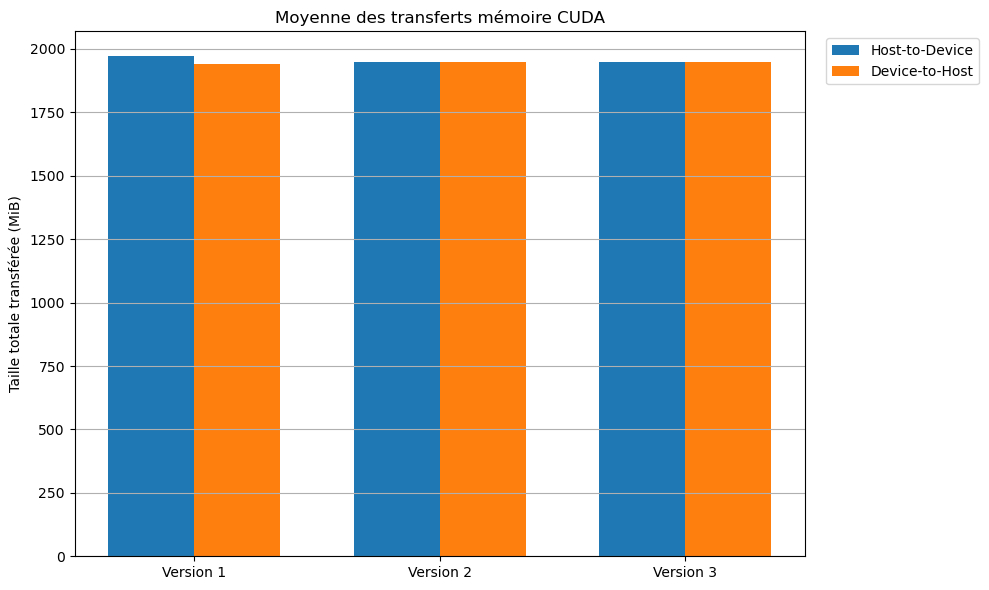

In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

def load_mem_data(file_path="memops_summary.json"):
    if not os.path.exists(file_path):
        print(f"Fichier {file_path} introuvable!")
        return []
    
    with open(file_path, 'r') as f:
        return json.load(f)

def prepare_mem_data(mem_data):
    raw_data = {}
    
    for entry in mem_data:
        version = entry["version"]
        if version not in raw_data:
            raw_data[version] = []
        
        raw_data[version].append(entry["data"])
    
    avg_data = {}
    for version, mem_list in raw_data.items():
        df = pd.DataFrame(mem_list)
        avg_data[version] = df.mean()
    
    return pd.DataFrame(avg_data).T

def plot_mem_data(df_avg):
    if df_avg.empty:
        print("Aucune donnée mémoire à visualiser")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    n_versions = len(df_avg)
    bar_width = 0.35
    index = np.arange(n_versions)
    
    for i, col in enumerate(df_avg.columns):
        ax.bar(index + i * bar_width, df_avg[col], bar_width, label=col)
    
    ax.set_title("Moyenne des transferts mémoire CUDA")
    ax.set_ylabel("Taille totale transférée (MiB)")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(df_avg.index)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig("memory_transfers_comparison.png", dpi=800)
    plt.show()


mem_json = load_mem_data()
df_mem_avg = prepare_mem_data(mem_json)
plot_mem_data(df_mem_avg)